In [61]:
from arcgis.gis import GIS
gis = GIS("home")

In [62]:
from arcgis.features import FeatureLayerCollection

In [63]:
get_ipython().system('pip install flickrapi')

DEPRECATION: Loading egg at /opt/conda/lib/python3.11/site-packages/tflite_model_maker-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [64]:
import flickrapi, os, json, time
from flickrapi.exceptions import FlickrError
import pandas as pd
import re
import ast
from typing import Union, Dict, List

In [65]:
#Set variables to authorize Flickr API call
org_u_name = 'FracTracker_Alliance'     #This is found directly under the oragnization name on your photostream.
key='2e503825e4a1d3e575a796bdcef05b80'    #replace key, secret, and u_name with FracTracker's information
secret='751c5ec03dcf0645'
u_name='xu.allen'

In [66]:
#Access Flickr API
flickr : flickr.FlickrAPI = flickrapi.FlickrAPI(key, secret, format='parsed-json')
flickr

[FlickrAPI for key "2e503825e4a1d3e575a796bdcef05b80"]

In [67]:
user_info   = flickr.people.findByUsername(username=org_u_name)    #Find user ID for FracTracker
user_info

{'user': {'id': '186454571@N08',
  'nsid': '186454571@N08',
  'username': {'_content': 'FracTracker_Alliance'}},
 'stat': 'ok'}

In [68]:
user_id : str = user_info['user']['id']         # Store User ID to string
user_id                                      

'186454571@N08'

In [69]:
# Set 'days' to at least the number of days between each update to the map data.
# (eg if the script is ran every 30 days, set days to 30 or higher. Duplicates will be updated to the latest data pull). 

days=90

cutoff_date = (pd.to_datetime('today') - pd.DateOffset(days)).strftime('%Y-%m-%d')
print(cutoff_date)

2024-12-11


# Setting up our Flickr API calls

In [70]:
# API call  for list all photos in the photostream within update interval and a set of their respective photo metadata.
def get_user_photos(user_id, per_page=500):     
    photos = []                                 
    page = 1                                    

    while True:
        response = flickr.people.getPhotos(    
            user_id=user_id,
            per_page=per_page,
            page=page,
            min_taken_date=cutoff_date, # If you want to pull all of the data, delete this argument.
            extras='geo, date_taken, description, url_l'  
        )
        photos.extend(response['photos']['photo'])
        if page >= response['photos']['pages']:
            break
        page += 1

    return photos

photos = get_user_photos(user_id) 
print(len(photos))

0


In [71]:
# API call for list of album metadata for a photo ID
def get_photo_albums(photo_id):      
    response = flickr.photos.getAllContexts(photo_id=photo_id)
    # Check if 'set' key exists in the response
    return response.get('set', [])


In [72]:
# Create dictionary of all necessary photo metadata
dataset = {}    
photo_count = 0  # Counter to track the number of photos processed

# Iterate over our list of photo metadata
for photo in photos:
    # Check if latitude and longitude exist and are not empty
    if 'latitude' in photo and 'longitude' in photo and photo['latitude'] and photo['longitude']: 
        photo_id = photo['id']
        albums = get_photo_albums(photo_id)      
        url = f"https://www.flickr.com/photos/fractracker/{photo_id}/"
        description = photo['description']['_content']

        dataset[photo_id] = {
            'PhotoID': photo_id,
            'Title': photo.get('title', ''),
            'Date_taken': photo.get('datetaken', ''),
            'URL': url,
            'AlbumTitle': [album['title'] for album in albums],
            'Description': description, 
            'Photo_src_URL': photo.get('url_l', ''),  # Large image URL
            'Latitude': photo.get('latitude', ''),  
            'Longitude': photo.get('longitude', '')
        }
        
        # Increment the photo counter
        photo_count += 1

        # Print progress every 200 photos
        if photo_count % 200 == 0:
            print(f"{photo_count} photos processed")

# Print the final count of processed photos
print(f"Processing complete. Total photos processed: {photo_count}")

Processing complete. Total photos processed: 0


In [73]:
# Store dicitonary values as a list of attributes
attributes = list(dataset.values())

In [74]:
attributes = list(dataset.values())    # Store dictionary values as a list of attributes
json_string = json.dumps(attributes)   # Convert to JSON formatted string
df = pd.read_json(json_string)         # Convert to Dataframe
df

""


In [75]:
# Creates fields if there are no new photos
columns_to_check = ['PhotoID', 'Title', 'Date_taken', 'URL', 'AlbumTitle', 'Description', 'Photo_src_URL', 'Latitude', 'Longitude']

for column in columns_to_check:
    if column not in df.columns:
        df[column] = None
df

,PhotoID,Title,Date_taken,URL,AlbumTitle,Description,Photo_src_URL,Latitude,Longitude


# Obtaining the 'Mission' and 'Mission Description' fields from the 'Title' field:

Now that we have all of our data in a PANDAS dataframe, we can use a series of string manipulation algorithms to obtain 
generally clean and well formatted 'Mission' and 'Mission Description' fields for all photos. 

Credit to Graham Joss for his extensive documentation.

#### Initial cleaning:

In [76]:
# Remove everything before the first and last Underscore to remove author and date information
df['Title_Middle'] = df['Title'].str.split('_').str[1:-1].str.join('_')

#### Saving LightHawk attribution as separate field and then removing it:

In [77]:
# Create the 'LightHawk' field and define as false
df['LightHawk'] = False

# Create filtered dataframe that only includes records with "lighthawk" in title
isLightHawk = df['Title_Middle'].map(lambda x: 'lighthawk' in x.split('-')[-1].lower()).copy(deep=True)  
df_lh = df[isLightHawk]

# Change 'LightHawk' to true for all records that share the same index as filtered dataframe
df.loc[df_lh.index, 'LightHawk'] = True  

In [78]:
# Delete LightHawk from title
def delJustLightHawk(x):
    xx = x.lower()
    if xx.endswith('lighthawk'): return x[:-10]
    return x
no_lighthawk = df['Title_Middle'].apply(delJustLightHawk).copy(deep=True)
df['Title_Mid_lh'] = no_lighthawk # New field without LightHawk
df

,PhotoID,Title,Date_taken,URL,AlbumTitle,Description,Photo_src_URL,Latitude,Longitude,Title_Middle,LightHawk,Title_Mid_lh


In [79]:
def delStateAndHyphen(x):
    pat = r"([A-Z]{2})$"
    match = re.search(pat, x)
    if match: 
        if x[-3] == '-' or '_': return x[:-3] # removing a state abbreviation and a hyphen 
        return x[:-2] # removing a state abbreviation
    elif x.endswith('-'):
        x = x[:-1]  # removing a hyphen
        match = re.search(pat, x)
        if match: return x[:-2] # removing a state abbreviation
        return x # already removed a hyphen
    return x # no change

no_st_or_hy = df.loc[:, 'Title_Mid_lh'].apply(delStateAndHyphen).copy(deep=True)
df['Title_Mid_lh_st']  = no_st_or_hy
df

,PhotoID,Title,Date_taken,URL,AlbumTitle,Description,Photo_src_URL,Latitude,Longitude,Title_Middle,LightHawk,Title_Mid_lh,Title_Mid_lh_st


#### Seperating 'Mission' from cleaned title field:

In [80]:
def mkMission(x):
    # Split on the first '-' or '_'
    x = x.split('-')[0].split('_')[0]  # Split on both and take the first part
    ret = ''
    for idx, let in enumerate(x):
        if let.isupper() and idx > 0:
            ret += ' '
            ret += let
        else:
            ret += let
    # Capitalize the first letter
    if ret and ret[0].islower():  # Check if ret is not empty
        ret = ret[0].upper() + ret[1:]
    return ret

# Apply the function to the DataFrame column
mission = df.loc[:, 'Title_Mid_lh_st'].map(mkMission).copy(deep=True)
df['Mission'] = mission
df

,PhotoID,Title,Date_taken,URL,AlbumTitle,Description,Photo_src_URL,Latitude,Longitude,Title_Middle,LightHawk,Title_Mid_lh,Title_Mid_lh_st,Mission


#### Removing county information from the Mission Description: 

In [81]:
# Split elements into an array
def mkMissionDescript (x):  
    return x.split('-')[1:]
mission_descript = df.loc[:, 'Title_Mid_lh_st'].map(mkMissionDescript).copy(deep=True)
df['Mission_Descript'] = mission_descript
df

,PhotoID,Title,Date_taken,URL,AlbumTitle,Description,Photo_src_URL,Latitude,Longitude,Title_Middle,LightHawk,Title_Mid_lh,Title_Mid_lh_st,Mission,Mission_Descript


In [82]:
# With our array, we create a dictionary of all of the last elements of each array that contain "county" for every record
cc =dict()
for i in df.loc[:, 'Mission_Descript'] : 
    c = i[-1].lower()
    if 'county' in c:
        if c in cc: cc[c] += 1
        else: cc[c] = 1 
cc, len(cc)

({}, 0)

In [83]:
# Now we go thru the Mission Descript column and if the the last element is in the dictionary, we will remove it
def delCounty(x):
    if x[-1].lower() in cc: 
        if len(x) > 1: return x[:-1]
    return x
no_county = df.loc[:, 'Mission_Descript'].apply(delCounty).copy(deep=True)
df['Mission Description'] = no_county

#### Reformatting our array into our final Mission Description:

In [84]:
# Reformat the mission description (initial step)
def reformatMissionDescript(x):
    s = ''.join(x)  # Convert input to string (if it's not already)
    s = s.replace('_', '')  # Remove underscores
    ret = ''
    for idx, let in enumerate(s):
        # Add a space before uppercase letters, unless the previous character is also uppercase
        if let.isupper() and idx > 0 and not s[idx - 1].isupper():
            ret += ' '
            ret += let
        else:
            ret += let
    return ret

# Additional function to handle abbreviations followed by a word
def separateAbbreviations(s):
    ret = ''
    i = 0
    while i < len(s):
        # Add the current character to the result
        ret += s[i]
        # Check if the current character is uppercase, the next character is uppercase,
        # and the character after that is lowercase
        if (
            i < len(s) - 2  # Ensure there are at least two characters ahead
            and s[i].isupper()
            and s[i + 1].isupper()
            and s[i + 2].islower()
        ):
            ret += ' '  # Add a space after the current character
        i += 1
    return ret

# Apply the initial reformatting
ff = df['Mission Description'].apply(reformatMissionDescript).copy(deep=True)

# Apply the additional function to handle abbreviations followed by a word
ff = ff.apply(separateAbbreviations)

# Update the DataFrame
df['Mission Description'] = ff

In [85]:
# Drop unnecessary columns generated for processing
df = df.drop(columns=['Title_Middle', 'Title_Mid_lh', 'Title_Mid_lh_st', 'Mission_Descript'])

# Our final, fully cleaned dataframe with all necessary fields included:

In [86]:
# Reorder to final configuration
new_order = ['PhotoID', 'Title', 'Date_taken', 'URL', 'Mission', 'Mission Description', 'AlbumTitle', 'Description', 
             'Photo_src_URL', 'LightHawk', 'Latitude', 'Longitude']
df = df[new_order]
df

,PhotoID,Title,Date_taken,URL,Mission,Mission Description,AlbumTitle,Description,Photo_src_URL,LightHawk,Latitude,Longitude


# Now, we will add this new data to our old existing data.

In [87]:
search_result = gis.content.search("Frac Tracker Photo Data", "CSV") #AGOL API call to read existing .csv into a dataframe:
if search_result:
    csv_item = search_result[0]
    # Download the file
    csv_path = csv_item.download(save_path='.')
    # Read the downloaded file
    df1 = pd.read_csv(csv_path)

else:
    print("File not found in ArcGIS Online.")

In [88]:
# How many records already exist?

df1.shape

(2874, 12)

In [89]:
# Convert string representations of lists to actual lists in df and df1
df1['AlbumTitle'] = df1['AlbumTitle'].apply(ast.literal_eval)

In [90]:
if len(df) > 0:
    dataframes = [df, df1]
    df2 = pd.concat(dataframes)
else:
    df2 = df1.copy(deep=True)
    # If there is no data, return a message
    print("No new data.")

df2.shape

No new data.


(2874, 12)

In [91]:
# Remove any duplicate photos (NOTE: any duplicates will be updated with the latest value!)
df2.drop_duplicates(subset='PhotoID', keep='last', inplace=True)
df2.shape

(2874, 12)

# Updating the map in ArcGIS Online

In [92]:
df2.to_csv('FracTrackerPhotoData.csv', index=False)

In [93]:
itemid='69573ae2b2404679b987a6016567104b'

<Item title:"Frac Tracker Photo Data" type:Feature Layer Collection owner:allen_f_xu3>
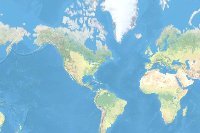

In [94]:
current_layer = gis.content.get(itemid)
current_layer

In [44]:
current_layer_flc = FeatureLayerCollection.fromitem(current_layer)

In [45]:
current_layer_flc.manager.overwrite('FracTrackerPhotoData.csv')

{'success': True}

# Map resources:

The Album and Mission filter need to have values added by hand. If there are any new values, they also need to be added by hand.

In [95]:
# Extract and flatten the AlbumTitle lists
all_album_titles = df2['AlbumTitle'].explode()
old_album_titles = df1['AlbumTitle'].explode()

# Get unique album titles
unique_album_titles = all_album_titles.unique()
old_unique = old_album_titles.unique()

# Convert unique album titles to a DataFrame
unique_album_titles_df = pd.DataFrame(unique_album_titles, columns=['AlbumTitle'])

new_albums = set(unique_album_titles) - set(old_unique)

new_albums_df = pd.DataFrame(new_albums, columns=['AlbumTitle'])
                                       
# Print each unique album title using a loop
print(f"There are {len(new_albums_df)} new albums added:")
for i in new_albums_df['AlbumTitle']:
    print(i)

There are 0 new albums added:


In [96]:
print(f"There are {len(unique_album_titles_df)} albums in total:")
for i in unique_album_titles_df['AlbumTitle']:
    print(i)

There are 54 albums in total:
Coastal & Marine Environments
Environmental Justice
Gulf Coast Buildout
Louisiana
Plastics & Petrochemicals
Refineries & Processing
Communities
Cracker Plants & Ethylene
Methane & Air and Water Quality Concerns
Michigan
Ontario_Canada
Pipelines
Pollution, Toxins, & Disposal Concerns
Movement Building
Culture & Livelihoods
Frac Sand Mining
Frac Sand Storage & Processing
Frac Sand Transportation
Wisconsin
Appalachian Buildout
Construction
Ohio
Channels of Life: the Gulf Coast Buildout in TX
Marshes, Swamps, & Wetlands
Offshore Drilling
Storage
Texas
Transportation
Liquefied Natural Gas (LNG)
nan
East Palestine Train Derailment
Waste & Wastewater
Explosions, Fires, & Flaring
Freshwater Ecosystems
Illinois
Wildlife
Pennsylvania
Drilling & Fracking
Southeastern Michigan Sand Mining & Industrial Impacts
Compressor Stations
Forests
Impoundment Ponds
Injection Wells
Coal Mining
Power Plants
Land Preservation & Management
Wind Energy
Water at Risk: the Lycoming Cre

In [97]:
# Extract and flatten the Mission lists
all_mission_titles = df2['Mission'].explode()
old_mission_titles = df1['Mission'].explode()

# Get unique album titles
unique_mission_titles = all_mission_titles.unique()
old_unique_m = old_mission_titles.unique()

# Convert unique album titles to a DataFrame
missionlist_df = pd.DataFrame(unique_mission_titles, columns=['Mission'])

new_missions = set(unique_mission_titles) - set(old_unique_m)
new_missions_df = pd.DataFrame(new_missions, columns=['Mission'])

# Print each unique album title using a loop
print(f"There are {len(new_missions_df)} new Mission categories:")
for i in new_missions_df['Mission']:
    print(i)

There are 0 new Mission categories:


In [98]:
# Print each unique album title using a loop
print(f"There are {len(missionlist_df)} Mission categories in total:")
for i in missionlist_df['Mission']:
    print(i)

There are 19 Mission categories in total:
Infrastructure
Movement Building
Environmental Justice
Transportation
Transport
Cultural
Community
Propaganda
Culture
Ecosystems
Communities
Renewable Energy
Construction
Frac Sand
Wildlife
Waste
Water
Mining
Plastics


In [99]:
# Extract and flatten the Mission Description lists
all_missiond_titles = df2['Mission Description'].explode()

# Get unique album titles
unique_missiond_titles = all_missiond_titles.unique()

# Convert unique album titles to a DataFrame
missiondlist_df = pd.DataFrame(unique_missiond_titles, columns=['Mission Description'])

# Print each unique album title using a loop
print("Unique Mission Descriptions:")
for i in missiondlist_df['Mission Description']:
    print(i)

Unique Mission Descriptions:
Oil Refinery PBF Chalmette Chalmette Louisiana
Grain Elevator Bunge St Rose Louisiana
Chemical Plant IMTT St Rose St Rose Louisiana
Oil Refinery Shell Norco Louisiana
Plastics Complex Denka Elastomers Belle Point Louisiana
Plastics Complex INEOS Sarnia Ontario
Plastics Complex NOVA Chemical Sarnia Ontario
Benzene Release INEOS Sarnia Ontario
Nitrogen Fertilizer Plant CF Industries Ascension Parish
Fertilizer Plant Mosaic St James Parish
Sugar Refinery Aluminum Plant Atlantic Alumina Louisiana Sugar St James Parish
Aluminum Processing Atlantic Alumina St James Parish
Oil Refinery Grain Elevator Marathon Archer Daniels Midland St James Parish
Power Plant Entergy St Charles Parish
Petrochemical Complex Dow Chemical Occidential Chemical St Charles Parish
Oil Refinery Shell St Charles Parish
Pesticide Plant Bayer Monsanto St Charles Parish
Grain Elevators Bunge Archer Daniels Midland St Charles Parish
Chemical Plant IMTT St Rose St Charles Parish
Chemical Plant 